## Task 1: Load the KDD99Cup data and prepare to train DOS vs non-DOS
We have downloaded the the KDD99Cup data and have it in the local directory as "kddcup.data". We have also created a file called "kddcup.headers" in the local directory, which is a space delimited list of the header names for the features. We load the data into a DataFrame. Then, we split the data set into a feature set and target set, and add the headers to the feature set.

In [1]:
# Load kddcup data. This was downloaded and placed in the same directory as the notebook.
# For header names, use file we created in the local directory called "kddcup.headers".
import pandas as pd
import numpy as np

df = pd.read_csv('kddcup.data')
headers = np.genfromtxt('kddcup.headers', dtype=str, delimiter=" ")

In [2]:
# Pull out the feature set and result set from the data
print(f"shape of data set: {df.shape}")
y = df.iloc[:, 41].values
X = df.iloc[:, 0:41]
X.columns = headers
print(f"shape of X: {X.shape}")
print(f"shape of y: {y.shape}")
print()

#Print the number of records of each class
from collections import Counter
class_counts = Counter(y)
print("Count of records of each type:")
for c in class_counts:
    print(f"{c}: {class_counts[c]}")

shape of data set: (4898430, 42)
shape of X: (4898430, 41)
shape of y: (4898430,)

Count of records of each type:
normal.: 972780
buffer_overflow.: 30
loadmodule.: 9
perl.: 3
neptune.: 1072017
smurf.: 2807886
guess_passwd.: 53
pod.: 264
teardrop.: 979
portsweep.: 10413
ipsweep.: 12481
land.: 21
ftp_write.: 8
back.: 2203
imap.: 12
satan.: 15892
phf.: 4
nmap.: 2316
multihop.: 7
warezmaster.: 20
warezclient.: 1020
spy.: 2
rootkit.: 10


In [3]:
# Look at the occurence of the different categories in the categorical features
print(Counter(X['protocol_type']))
print(Counter(X['service']))
print(Counter(X['flag']))

Counter({'icmp': 2833545, 'tcp': 1870597, 'udp': 194288})
Counter({'ecr_i': 2811660, 'private': 1100831, 'http': 623090, 'smtp': 96554, 'other': 72653, 'domain_u': 57782, 'ftp_data': 40697, 'eco_i': 16338, 'finger': 6891, 'urp_i': 5378, 'ftp': 5214, 'telnet': 4277, 'ntp_u': 3833, 'auth': 3382, 'pop_3': 1981, 'time': 1579, 'domain': 1113, 'Z39_50': 1078, 'gopher': 1077, 'mtp': 1076, 'ssh': 1075, 'whois': 1073, 'remote_job': 1073, 'rje': 1070, 'link': 1069, 'imap4': 1069, 'ctf': 1068, 'name': 1067, 'supdup': 1060, 'echo': 1059, 'discard': 1059, 'nntp': 1059, 'uucp_path': 1057, 'netstat': 1056, 'daytime': 1056, 'systat': 1056, 'sunrpc': 1056, 'netbios_ssn': 1055, 'pop_2': 1055, 'netbios_ns': 1054, 'vmnet': 1053, 'netbios_dgm': 1052, 'sql_net': 1052, 'iso_tsap': 1052, 'shell': 1051, 'csnet_ns': 1051, 'klogin': 1050, 'hostnames': 1050, 'bgp': 1047, 'login': 1045, 'exec': 1045, 'printer': 1045, 'http_443': 1044, 'efs': 1042, 'uucp': 1041, 'ldap': 1041, 'kshell': 1040, 'nnsp': 1038, 'courier'

In [4]:
# Convert classes in y to success (1) or failure (-1).
# ipsweep probe, portsweep probe, nmap probe, and sata probe should be considered successes (1).
# Any other value, including normal, is considered a failure case (-1).
import numpy as np
y = np.where(y=="back.", 1, y)
y = np.where(y=="land.", 1, y)
y = np.where(y=="neptune.", 1, y)
y = np.where(y=="pod.", 1, y)
y = np.where(y=="smurf.", 1, y)
y = np.where(y=="teardrop.", 1, y)

y = np.where(y==1, y, -1)
y = y.astype('int')
print(Counter(y))

Counter({1: 3883370, -1: 1015060})


In [5]:
# Dataset is unbalanced, we have many more failure cases than success cases. Use RandomUnderSampler to 
# balance the number of records of each type.
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler 

print('Original dataset shape %s' % Counter(y))
rus = RandomUnderSampler(random_state=0, sampling_strategy={1:100000, -1:100000})
X1, y1 = rus.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y1))
print(X1.shape)

Original dataset shape Counter({1: 3883370, -1: 1015060})
Resampled dataset shape Counter({-1: 100000, 1: 100000})
(200000, 41)


In [6]:
# Use OneHotEncoder on protocol_type
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse=False)
X2 = pd.DataFrame(enc.fit_transform(X1[['protocol_type']]))
X2.columns = enc.get_feature_names_out(['protocol_type'])
X3 = X1.copy()
X3.drop(['protocol_type'], axis=1, inplace=True)
X4 = pd.concat([X3, X2], axis=1)
print(X4.shape)

(200000, 43)


In [7]:
# Use OneHotEncoder on service
X5 = pd.DataFrame(enc.fit_transform(X4[['service']]))
X5.columns = enc.get_feature_names_out(['service'])
X6 = X4.copy()
X6.drop(['service'], axis=1, inplace=True)
X7 = pd.concat([X6, X5 ], axis=1)
print(X7.shape)

(200000, 106)


In [8]:
# Use OneHotEncoder on flag
X8 = pd.DataFrame(enc.fit_transform(X7[['flag']]))
X8.columns = enc.get_feature_names_out(['flag'])
X9 = X7.copy()
X9.drop(['flag'], axis=1, inplace=True)
X10 = pd.concat([X9, X8], axis=1)
print(X10.shape)

(200000, 116)


In [9]:
# Store final feature set into X_encoded
X_encoded = X10

In [10]:
# Standardize the feature set data to help with training.
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_encoded)
X_scaled = scaler.transform(X_encoded)

In [11]:
# Then split the data into a training set (80%) and testing set (20%).
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y1, test_size=0.2, random_state=0)
print(f"training set shape: {X_train.shape}")
print(f"testing set shape: {X_test.shape}")

training set shape: (160000, 116)
testing set shape: (40000, 116)


### Train and test with "rbf" kernel

In [12]:
from sklearn.svm import SVC

svm1 = SVC(kernel='rbf', random_state=0)
print(svm1.get_params())
svm1.fit(X_train, y_train)

print(f"iterations required: {svm1.n_iter_}")

{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': 0, 'shrinking': True, 'tol': 0.001, 'verbose': False}
iterations required: [1533]


In [13]:
# Build classification report for training data set
from sklearn.metrics import classification_report

target_labels = [1, -1]
target_names = ['dns', 'nondns']
y_pred_train = svm1.predict(X_train)
print(classification_report(y_train, y_pred_train, labels=target_labels, target_names=target_names, digits=4))

              precision    recall  f1-score   support

         dns     0.9998    0.9995    0.9996     79913
      nondns     0.9995    0.9998    0.9996     80087

    accuracy                         0.9996    160000
   macro avg     0.9996    0.9996    0.9996    160000
weighted avg     0.9996    0.9996    0.9996    160000



In [14]:
# Build classification report for test data set
from sklearn.metrics import classification_report

target_labels = [1, -1]
target_names = ['dns', 'nondns']
y_pred_test = svm1.predict(X_test)
print(classification_report(y_test, y_pred_test, labels=target_labels, target_names=target_names, digits=4))

              precision    recall  f1-score   support

         dns     0.9995    0.9997    0.9996     20087
      nondns     0.9996    0.9994    0.9995     19913

    accuracy                         0.9996     40000
   macro avg     0.9996    0.9995    0.9995     40000
weighted avg     0.9996    0.9996    0.9995     40000



### Train and test with "linear" kernel

In [15]:
from sklearn.svm import SVC

svm2 = SVC(kernel='linear', random_state=0)
print(svm2.get_params())
svm2.fit(X_train, y_train)

print(f"iterations required: {svm2.n_iter_}")

{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': 0, 'shrinking': True, 'tol': 0.001, 'verbose': False}
iterations required: [15030]


In [16]:
# Build classification report for training data set
from sklearn.metrics import classification_report

target_labels = [1, -1]
target_names = ['dns', 'nondns']
y_pred_train = svm2.predict(X_train)
print(classification_report(y_train, y_pred_train, labels=target_labels, target_names=target_names, digits=4))

              precision    recall  f1-score   support

         dns     0.9998    0.9998    0.9998     79913
      nondns     0.9998    0.9998    0.9998     80087

    accuracy                         0.9998    160000
   macro avg     0.9998    0.9998    0.9998    160000
weighted avg     0.9998    0.9998    0.9998    160000



In [17]:
# Build classification report for test data set
from sklearn.metrics import classification_report

target_labels = [1, -1]
target_names = ['dns', 'nondns']
y_pred_test = svm2.predict(X_test)
print(classification_report(y_test, y_pred_test, labels=target_labels, target_names=target_names, digits=4))

              precision    recall  f1-score   support

         dns     0.9993    0.9997    0.9995     20087
      nondns     0.9997    0.9992    0.9995     19913

    accuracy                         0.9995     40000
   macro avg     0.9995    0.9995    0.9995     40000
weighted avg     0.9995    0.9995    0.9995     40000



### Train and test with "poly" kernel

In [18]:
from sklearn.svm import SVC

svm3 = SVC(kernel='poly', random_state=0)
print(svm3.get_params())
svm3.fit(X_train, y_train)

print(f"iterations required: {svm3.n_iter_}")

{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'poly', 'max_iter': -1, 'probability': False, 'random_state': 0, 'shrinking': True, 'tol': 0.001, 'verbose': False}
iterations required: [2689]


In [19]:
# Build classification report for training data set
from sklearn.metrics import classification_report

target_labels = [1, -1]
target_names = ['dns', 'nondns']
y_pred_train = svm3.predict(X_train)
print(classification_report(y_train, y_pred_train, labels=target_labels, target_names=target_names, digits=4))

              precision    recall  f1-score   support

         dns     1.0000    0.9993    0.9996     79913
      nondns     0.9993    1.0000    0.9997     80087

    accuracy                         0.9997    160000
   macro avg     0.9997    0.9996    0.9996    160000
weighted avg     0.9997    0.9997    0.9996    160000



In [20]:
# Build classification report for test data set
from sklearn.metrics import classification_report

target_labels = [1, -1]
target_names = ['dns', 'nondns']
y_pred_test = svm3.predict(X_test)
print(classification_report(y_test, y_pred_test, labels=target_labels, target_names=target_names, digits=4))

              precision    recall  f1-score   support

         dns     1.0000    0.9996    0.9998     20087
      nondns     0.9996    0.9999    0.9998     19913

    accuracy                         0.9998     40000
   macro avg     0.9998    0.9998    0.9998     40000
weighted avg     0.9998    0.9998    0.9998     40000



### Train and test with "sigmoid" kernel

In [21]:
from sklearn.svm import SVC

svm4 = SVC(kernel='sigmoid', random_state=0)
print(svm4.get_params())
svm4.fit(X_train, y_train)

print(f"iterations required: {svm4.n_iter_}")

{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'sigmoid', 'max_iter': -1, 'probability': False, 'random_state': 0, 'shrinking': True, 'tol': 0.001, 'verbose': False}
iterations required: [1085]


In [22]:
# Build classification report for training data set
from sklearn.metrics import classification_report

target_labels = [1, -1]
target_names = ['dns', 'nondns']
y_pred_train = svm4.predict(X_train)
print(classification_report(y_train, y_pred_train, labels=target_labels, target_names=target_names, digits=4))

              precision    recall  f1-score   support

         dns     0.9981    0.9983    0.9982     79913
      nondns     0.9983    0.9981    0.9982     80087

    accuracy                         0.9982    160000
   macro avg     0.9982    0.9982    0.9982    160000
weighted avg     0.9982    0.9982    0.9982    160000



In [23]:
# Build classification report for test data set
from sklearn.metrics import classification_report

target_labels = [1, -1]
target_names = ['dns', 'nondns']
y_pred_test = svm4.predict(X_test)
print(classification_report(y_test, y_pred_test, labels=target_labels, target_names=target_names, digits=4))

              precision    recall  f1-score   support

         dns     0.9973    0.9988    0.9980     20087
      nondns     0.9987    0.9973    0.9980     19913

    accuracy                         0.9980     40000
   macro avg     0.9980    0.9980    0.9980     40000
weighted avg     0.9980    0.9980    0.9980     40000



### Compare Kernels

In [24]:
# Generate scores
scores = []
scores.append(svm1.score(X_test, y_test))
scores.append(svm2.score(X_test, y_test))
scores.append(svm3.score(X_test, y_test))
scores.append(svm4.score(X_test, y_test))

In [25]:
print(scores)

[0.99955, 0.999475, 0.999775, 0.998025]


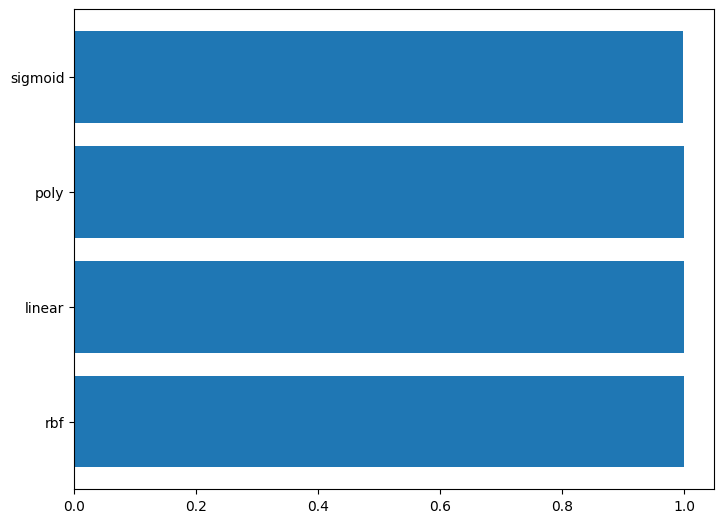

In [26]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
kernels = ['rbf', 'linear', 'poly', 'sigmoid']
ax.barh(kernels,scores)
plt.autoscale()
plt.show()

## Find important features using LogisticRegression

In [27]:
# Train the LogisticRegression model with the training data.
# After trial and error, 300 is roughly the minimum number of iterations at which the training will converge.
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=0, max_iter=5000)
print(lr.get_params())
lr.fit(X_train, y_train)
print(f"iterations required: {lr.n_iter_}")

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 5000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 0, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
iterations required: [147]


In [28]:
# Build classification report for training data set
from sklearn.metrics import classification_report

target_labels = [1, -1]
target_names = ['dns', 'nondns']
y_pred_train = lr.predict(X_train)
print(classification_report(y_train, y_pred_train, labels=target_labels, target_names=target_names, digits=4))

              precision    recall  f1-score   support

         dns     0.9998    0.9998    0.9998     79913
      nondns     0.9998    0.9998    0.9998     80087

    accuracy                         0.9998    160000
   macro avg     0.9998    0.9998    0.9998    160000
weighted avg     0.9998    0.9998    0.9998    160000



In [29]:
# Build classification report for test data set
from sklearn.metrics import classification_report

target_labels = [1, -1]
target_names = ['dns', 'nondns']
y_pred_train = lr.predict(X_test)
print(classification_report(y_test, y_pred_test, labels=target_labels, target_names=target_names, digits=4))

              precision    recall  f1-score   support

         dns     0.9973    0.9988    0.9980     20087
      nondns     0.9987    0.9973    0.9980     19913

    accuracy                         0.9980     40000
   macro avg     0.9980    0.9980    0.9980     40000
weighted avg     0.9980    0.9980    0.9980     40000



In [30]:
# Print number of each feature with its coeffiecient, in sorted order
numFeatures = lr.coef_[0].size
sorted_coef = np.empty(shape = (numFeatures,2), dtype=object)
for i in range(numFeatures):
    sorted_coef[i, 0] = i
    sorted_coef[i, 1] = lr.coef_[0][i]

sorted_coef = sorted_coef[sorted_coef[:,1].argsort()] 

print("Most positively correlated features:")    
for rank in range (numFeatures-1,numFeatures-6,-1): 
    colnum, coef = sorted_coef[rank]
    print(f"{X_encoded.columns[colnum]} ({colnum}): {coef:6.2f}")    

print()
print("Most negatively correlated features:")
for coef_num, coef_val in sorted_coef[0:5]:    
    print(f"{X_encoded.columns[coef_num]} ({coef_num}): {coef_val:6.2f}")

Most positively correlated features:
srv_count (20):   3.25
dst_host_serror_rate (34):   3.25
hot (6):   2.95
count (19):   2.48
service_ecr_i (55):   2.14

Most negatively correlated features:
is_guest_login (18):  -5.07
dst_host_same_src_port_rate (32):  -2.11
dst_host_diff_srv_rate (31):  -2.02
protocol_type_udp (40):  -1.81
same_srv_rate (25):  -1.65


## Train using 2 features

In [31]:
# Pull out the feature set and result set from the data
print(f"shape of data set: {df.shape}")
print(X.columns)

# Include only srv_count and dst_host_same_src_port_rate
X20 = X.iloc[:, [23, 35]]
print(f"shape of X: {X20.shape}")
print(X20)

shape of data set: (4898430, 42)
Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate'],
      dtype='object')
shape of X: (4898430, 2)
         srv_count  dst_host_same_src_port_rate
0                2                         1.00
1   

In [32]:
# Dataset is unbalanced, we have many more failure cases than success cases. Use RandomUnderSampler to 
# balance the number of records of each type.
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler 

print('Original dataset shape %s' % Counter(y))
rus = RandomUnderSampler(random_state=0, sampling_strategy={1:50, -1:50})
X21, y21 = rus.fit_resample(X20, y)
print('Resampled dataset shape %s' % Counter(y21))
print(X21.shape)

Original dataset shape Counter({1: 3883370, -1: 1015060})
Resampled dataset shape Counter({-1: 50, 1: 50})
(100, 2)


In [33]:
# Standardize the feature set data to help with training.
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X21)
X22 = scaler.transform(X21)
y22 = y21

In [34]:
# Create arrays for plotting the data set
pos_feat1 = []
pos_feat2 = []
neg_feat1 = []
neg_feat2 = []

for i in range(y21.size):
    if y21[i] == 1:
        pos_feat1.append(X22[i][0])
        pos_feat2.append(X22[i][1])
    else:
        neg_feat1.append(X22[i][0])
        neg_feat2.append(X22[i][1])

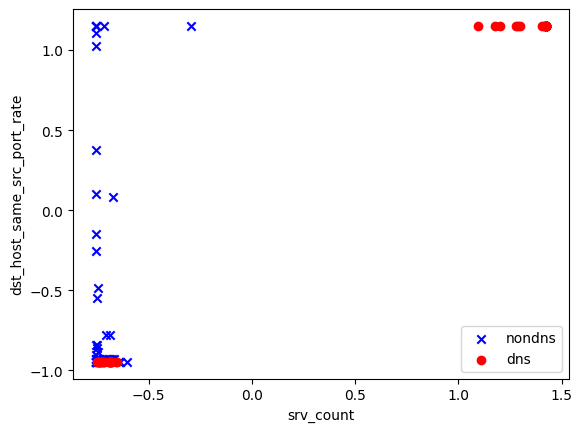

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt

# plot data
plt.scatter(neg_feat1, neg_feat2,
            color='blue', marker='x', label='nondns')
plt.scatter(pos_feat1, pos_feat2,
            color='red', marker='o', label='dns')

plt.xlabel('srv_count')
plt.ylabel('dst_host_same_src_port_rate')
plt.legend(loc='lower right')

plt.show()

## Train against linear kernel

In [36]:
from sklearn.svm import SVC

svm5 = SVC(kernel='linear', random_state=0)
print(svm5.get_params())
svm5.fit(X22, y22)

print(f"iterations required: {svm5.n_iter_}")

{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': 0, 'shrinking': True, 'tol': 0.001, 'verbose': False}
iterations required: [42]


In [37]:
from matplotlib.colors import ListedColormap


def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('o', 's', 'x', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

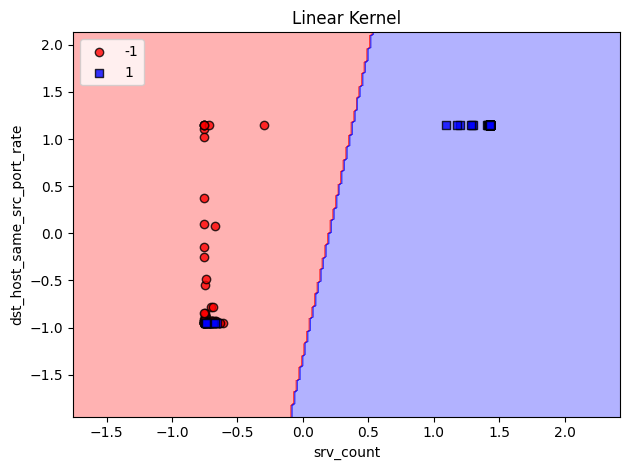

In [38]:
plot_decision_regions(X22, y22, classifier=svm5)
plt.title('Linear Kernel')
plt.xlabel('srv_count')
plt.ylabel('dst_host_same_src_port_rate')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

## Train against RBF kernel

In [39]:
from sklearn.svm import SVC

svm6 = SVC(kernel='rbf', random_state=0)
print(svm6.get_params())
svm6.fit(X22, y22)

print(f"iterations required: {svm6.n_iter_}")

{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': 0, 'shrinking': True, 'tol': 0.001, 'verbose': False}
iterations required: [26]


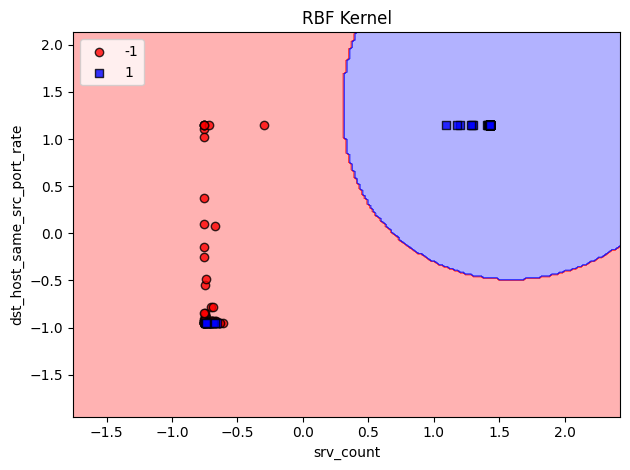

In [40]:
plot_decision_regions(X22, y22, classifier=svm6)
plt.title('RBF Kernel')
plt.xlabel('srv_count')
plt.ylabel('dst_host_same_src_port_rate')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()